In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from langdetect import detect
import re
import os
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import datetime
plt.style.use('seaborn')
import operator


from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, GRU, Embedding, Layer, RepeatVector, TimeDistributed
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import pydot

from src.helpme_l2_drop import *

In [4]:
df_test = pd.read_csv('data/kor.txt', sep='\t', names=['eng','kor','drop_me'])
df_test = df_test.drop(columns='drop_me')

df_test = df_test.drop([3317,3316])

df_test = df_test[:-30]



eng = preprocess(df_test['eng'])
kor = preprocess(df_test['kor'])

input_tensor, input_lang_tokenizer = tokenize(eng)
target_tensor, target_lang_tokenizer = tokenize(kor)

eng_test_vocab_size = len(input_lang_tokenizer.word_index)+1
kor_test_vocab_size = len(target_lang_tokenizer.word_index)+1

print(f'English vocab size: {eng_test_vocab_size}')
print(f'Korean vocab size: {kor_test_vocab_size}')

eng_test_max_length = len(input_tensor[0])
kor_test_max_length = len(target_tensor[0])

print(f'Longest English Sentence: {eng_test_max_length}')
print(f'Longest Korean Sentence: {kor_test_max_length}')

English vocab size: 2293
Korean vocab size: 4934
Longest English Sentence: 16
Longest Korean Sentence: 15


In [5]:
eng_word_counts = input_lang_tokenizer.word_counts
kor_word_counts = target_lang_tokenizer.word_counts

sorted_eng_word_counts = sorted(eng_word_counts.items(), key=operator.itemgetter(1), reverse=True)
sorted_kor_word_counts = sorted(kor_word_counts.items(), key=operator.itemgetter(1), reverse=True)

top_20_eng_words = sorted_eng_word_counts[2:20]

top_20_kor_words = sorted_kor_word_counts[2:20]

In [6]:
top_20_eng_words

[('i', 986),
 ('tom', 859),
 ('is', 663),
 ('to', 615),
 ('you', 568),
 ('a', 450),
 ('the', 418),
 ('not', 407),
 ('do', 306),
 ('that', 258),
 ('have', 212),
 ('in', 199),
 ('are', 182),
 ('it', 170),
 ('am', 167),
 ('this', 161),
 ('was', 161),
 ('my', 137)]

In [7]:
top_20_kor_words

[('톰은', 491),
 ('있어', 291),
 ('난', 235),
 ('톰이', 219),
 ('나는', 168),
 ('그', 114),
 ('내가', 112),
 ('수', 100),
 ('내', 97),
 ('이', 79),
 ('것', 74),
 ('네가', 70),
 ('같아', 62),
 ('않아', 60),
 ('너', 58),
 ('없어', 57),
 ('거야', 56),
 ('더', 53)]

In [8]:
x, y = zip(*top_20_eng_words)

<BarContainer object of 18 artists>

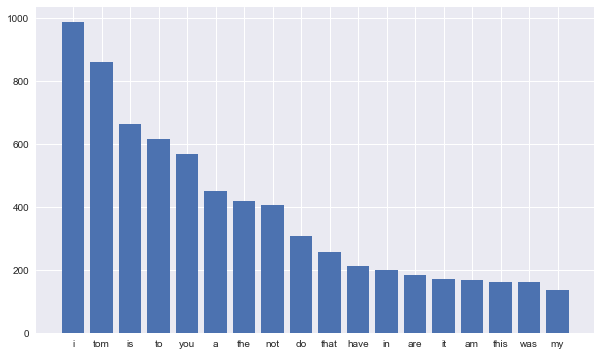

In [9]:
fig,ax = plt.subplots(figsize=(10,6))
ax.bar(x,y)
# plt.savefig('eng_words.png')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(input_tensor,target_tensor, test_size=.15)

In [11]:
y_train_test = encode_output(y_train, kor_test_vocab_size)
y_test_test = encode_output(y_test, kor_test_vocab_size)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 50)            114650    
_________________________________________________________________
lstm (LSTM)                  (None, 50)                20200     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 15, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 50)            20200     
_________________________________________________________________
time_distributed (TimeDistri (None, 15, 4934)          251634    
Total params: 406,684
Trainable params: 406,684
Non-trainable params: 0
_________________________________________________________________
None


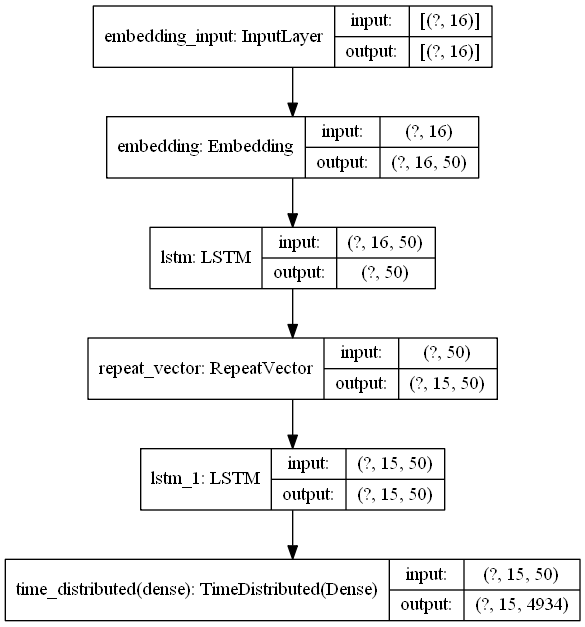

In [12]:
# define model
model = define_model(eng_test_vocab_size, kor_test_vocab_size, eng_test_max_length, kor_test_max_length, 50)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'])
# summarize defined model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

In [13]:
log_dir="logs/fit/"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=1000000)

In [14]:
filename = 'model_test.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_acc', verbose=1, save_best_only=True)


In [15]:
history = model.fit(X_train, y_train_test, epochs=50, batch_size=20, validation_data=(X_test, y_test_test), callbacks=[checkpoint,tensorboard_callback], verbose=2)

Train on 2793 samples, validate on 493 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.59026, saving model to model_test.h5
2793/2793 - 18s - loss: 5.3145 - acc: 0.5850 - val_loss: 3.2349 - val_acc: 0.5903
Epoch 2/50

Epoch 00002: val_acc improved from 0.59026 to 0.65693, saving model to model_test.h5
2793/2793 - 3s - loss: 2.9343 - acc: 0.6041 - val_loss: 2.9032 - val_acc: 0.6569
Epoch 3/50

Epoch 00003: val_acc did not improve from 0.65693
2793/2793 - 3s - loss: 2.6803 - acc: 0.6597 - val_loss: 2.7810 - val_acc: 0.6569
Epoch 4/50

Epoch 00004: val_acc did not improve from 0.65693
2793/2793 - 3s - loss: 2.5379 - acc: 0.6597 - val_loss: 2.6779 - val_acc: 0.6569
Epoch 5/50

Epoch 00005: val_acc improved from 0.65693 to 0.66410, saving model to model_test.h5
2793/2793 - 3s - loss: 2.4234 - acc: 0.6609 - val_loss: 2.6184 - val_acc: 0.6641
Epoch 6/50

Epoch 00006: val_acc did not improve from 0.66410
2793/2793 - 3s - loss: 2.3428 - acc: 0.6666 - val_loss: 2.6014 - val_acc:

In [24]:
model.save('model.h5')

In [16]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

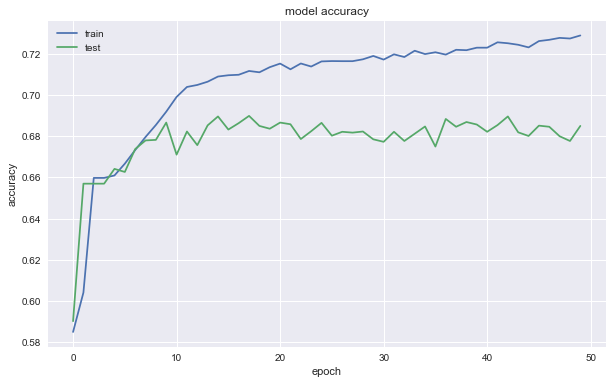

In [17]:
fig,ax = plt.subplots(figsize=(10,6))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig('acc_plot.png')

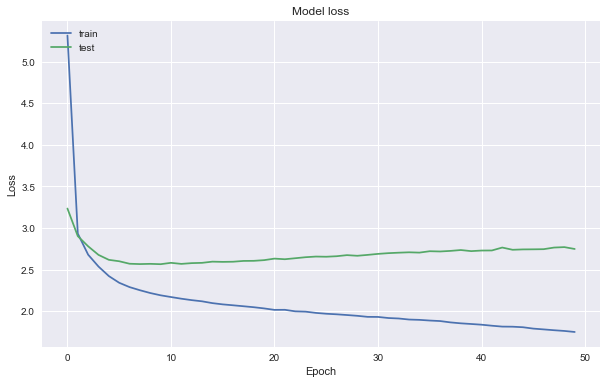

In [18]:
fig,ax = plt.subplots(figsize=(10,6))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Model loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#plt.savefig('acc_plot.png')

In [19]:
decode_input(input_tensor,2000,input_lang_tokenizer)

'<start> where am i supposed to sleep'

In [22]:
sentence1 = "where am i supposed to sleep"

test_sentence = encode_sentence(sentence1, input_lang_tokenizer,eng_test_max_length)

test_sentence

array([   1,   76,   17,    3, 1062,    6,  215,    2,    0,    0,    0,
          0,    0,    0,    0,    0])

In [23]:
predict_sequence(model,target_lang_tokenizer,test_sentence)

'<start> 난 내가 수 있어'